In [1]:
import numpy as np
#for some reason, matplotlib crashes without these lines
a = np.zeros((5,5))
a@a
import matplotlib.pyplot as plt
from utils import get_mesh_vtk
from utils import get_data
from utils import strip_cross, reconstruct_cross
from KPCA import *
import KPCA
import Autoencoder
# from torchsummary import summary
# from Autoencoder import Autoencoder
import torch
import torch.nn as nn
from utils import calc_energy, torch2np
import glob
import os
# from importlib import reload

In [2]:
def read_from_ds(Wi, beta, ds_path=None):
    if ds_path is None:
        ds_path = '../npz_data/crossTurb_train'

    files = glob.glob(f'*Wi{Wi:g}_beta{beta:g}*.pt', root_dir=ds_path)
    X = torch.load(f'{ds_path}/{files[0]}')['tensor']
    data = torch.zeros([len(files)] + [s for s in X.shape])
    for i,file in enumerate(files):
        data[i] = torch.load(f'{ds_path}/{file}')['tensor']
    return data

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [3]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

In [4]:
# Read the meshgrid for computing the energy

vtk_file = '../npz_data/Dados-N0.vtk'
x, y = get_mesh_vtk(vtk_file)
cut = 13 # removes the influence of inflow/outflow
dx = x[1:] - x[:-1]
dy = y[1:] - y[:-1]
DX, DY = np.meshgrid(dx,dy)
DX = strip_cross(DX[...,None,None], cut).squeeze()
DY = strip_cross(DY[...,None,None], cut).squeeze()

xc = (x[1:] + x[:-1])/2
yc = (y[1:] + y[:-1])/2
X_mesh, Y_mesh = np.meshgrid(xc,yc)
X_mesh = strip_cross(X_mesh[...,None,None], cut).squeeze()
Y_mesh = strip_cross(Y_mesh[...,None,None], cut).squeeze()

Xr_mesh = reconstruct_cross(X_mesh[:,None, None], cut).squeeze()
Yr_mesh = reconstruct_cross(Y_mesh[:,None, None], cut).squeeze()

Xr_mesh[:65-cut,:65-cut] = 11
Xr_mesh[-65+cut:,:65-cut] = 11
Xr_mesh[:65-cut,-65+cut:] = 11
Xr_mesh[-65+cut:,-65+cut:] = 11

Yr_mesh[:65-cut,:65-cut] = 11
Yr_mesh[-65+cut:,:65-cut] = 11
Yr_mesh[:65-cut,-65+cut:] = 11
Yr_mesh[-65+cut:,-65+cut:] = 11

In [5]:
# NN part
small = True # Use less parameter in the architechture

latent_dim = 3
autoencoder = Autoencoder.ParametricVAEModule(n_input= DX.shape[0], latent_dim = latent_dim, max_in=torch.zeros((1,5,1)), min_in=torch.zeros((1,5,1)), small = small).to(device)
if small:
    autoencoder.load_state_dict(torch.load(f'../Models/VAE_CrossParametric_Latent_{latent_dim}_small/best_autoencoder',map_location=torch.device('cpu')))
else:
    autoencoder.load_state_dict(torch.load(f'../Models/VAE_CrossParametric_Latent_{latent_dim}/best_autoencoder',map_location=torch.device('cpu')))

print(get_n_params(autoencoder))

56397127


In [6]:
Re = 0.01
# Parameters:
parameters = [
        (0.8, 0.11111), # Outlier
        (2.5, 0.11111), # 1
        (2.5, 0.22222), # 2
        (2.5, 0.33333), # 3
        (2.5, 0.44444), # 4
        (3.0, 0.11111), # 5
        (3.0, 0.22222), # 6
        (3.5, 0.11111), # 7
        (3.5, 0.22222), # 8
        (3.5, 0.33333), # 9
        (4.0, 0.33333), # 10
        (4.5, 0.11111), # 11
        (4.5, 0.22222), # 12
        (4.5, 0.33333), # 13
        (5.0, 0.11111), # 14
        (5.0, 0.22222), # 15
        (5.0, 0.33333), # 16
        (5.5, 0.11111), # 17
        (5.5, 0.33333), # 18
        (6.0, 0.22222), # 19
        (6.0, 0.44444), # 20
        (6.5, 0.11111), # 21
        (6.5, 0.33333), # 22
        (7.0, 0.11111), # 23
        (7.0, 0.22222), # 24
        (7.0, 0.44444), # 25
        (7.5, 0.11111), # 26
        # test
        (4.0, 0.22222), # -2 (27)
        (7.5, 0.33333)  # -1 (28)
]


In [31]:
Xpca = np.zeros((66045,0))
Parampca = np.zeros((0,2))
training_index = range(1,27,3)
for i in training_index:
# for i in [1,2, 4]:
    Wi_temp ,beta_temp = parameters[i]
    params_temp = [Wi_temp, beta_temp]

    X_temp = read_from_ds(*params_temp, ds_path='../npz_data/crossTurb_train')
    Xt = torch2np(X_temp)
    param_temp = np.ones((X_temp.shape[0], 2))
    param_temp[:] = params_temp

    Xpca = np.concatenate((Xpca,Xt), axis=1)
    Parampca = np.concatenate((Parampca,param_temp), axis=0)

print(Xpca.shape)
print(Parampca.shape)
print('Training indexes:', [i for i in training_index])

Wi_arr = Parampca[:,0]
beta_arr = Parampca[:,1]

theta_pca = ((1-beta_arr)/(Re * Wi_arr))[:,None]
theta_pca_sqrt = np.sqrt(theta_pca@theta_pca.T)

print(theta_pca_sqrt.shape)

Data shape:  (66045, 999)
theta shape:  (999, 1)


In [8]:


degree = 1
ncomp = latent_dim 

KPCA_linear = KPCA.KernelPCA()
KPCA_oldroyd = KPCA.KernelPCA()

KPCA_linear.fit(Xpca.T, n_components=ncomp, kernel='linear', gamma=theta_pca_sqrt, norm='DIV', eps = None, degree = degree)
KPCA_oldroyd.fit(Xpca.T, n_components=ncomp, kernel='oldroyd', gamma=theta_pca_sqrt, norm='DIV', eps = None, dx = DX[None,:], dy = DY[None,:], degree = degree)


(66045, 8991)
(8991, 2)
Training indexes: [1, 4, 7, 10, 13, 16, 19, 22, 25]
(8991, 8991)


In [52]:

## Data reading
ind = -2
Wi ,beta = parameters[ind]
params = [Wi, beta]

if (ind < 0 and ind > -3) or ind > 26:
    dspath = '../npz_data/crossTurb_test'
else:
    dspath = '../npz_data/crossTurb_train'

X_torch = read_from_ds(*params, ds_path=dspath)
X = torch2np(X_torch)
param = torch.ones((X_torch.shape[0], 2)).float()
param[:] = torch.Tensor(params).float()


Wi_data = param[:,0].numpy()
beta_data = param[:,1].numpy()

theta_data = ((1-beta_data)/(Re * Wi_data))[:,None]

print('Data shape: ',X.shape)
print('theta shape: ',theta_data.shape)

Data shape:  (66045, 999)
theta shape:  (999, 1)


In [53]:
# Run test
with torch.no_grad():
    _, code, _ = autoencoder.encode(X_torch, param)
    X_ae_torch= autoencoder.decode(code, param)
    # X_ae_torch,_,_ = autoencoder(X_torch.float(), param.float())
X_ae = torch2np(X_ae_torch)

In [54]:
theta = np.sqrt(theta_data@theta_pca.T)

phi_linear = KPCA_linear.transform(X.T, gamma = theta, eps = None)
phi_oldroyd = KPCA_oldroyd.transform(X.T, gamma = theta, eps = None,dx = DX[None,:], dy = DY[None,:])

X_linear = KPCA_linear.invert_transform(phi_linear)
X_oldroyd = KPCA_oldroyd.invert_transform(phi_oldroyd)

In [55]:
# Energy From data
elastic, kinetic, total = calc_energy(X,Wi,beta,Re, dx = DX[:,None], dy = DY[:,None])

# # Energy From Autoencoder
elastic_ae, kinetic_ae, total_ae = calc_energy(X_ae,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

# Energy From PCA
elastic_linear, kinetic_linear, total_linear = calc_energy(X_linear,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])
# Energy From KPCA
elastic_oldroyd, kinetic_oldroyd, total_oldroyd = calc_energy(X_oldroyd,Wi,beta,Re,dx = DX[:,None], dy = DY[:,None])

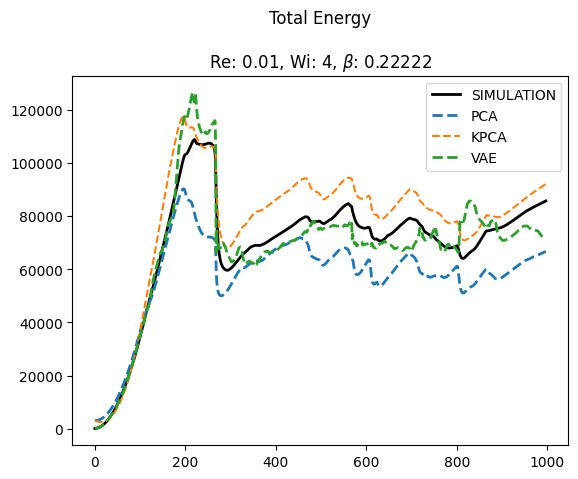

In [56]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')

plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Total Energy\n\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()
# plt.title('Total Energy')
# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

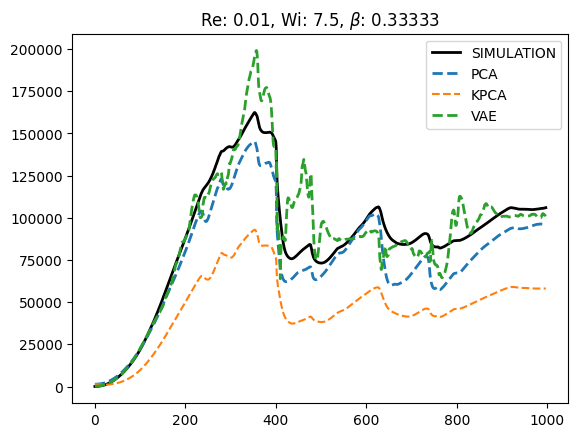

In [28]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')

plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

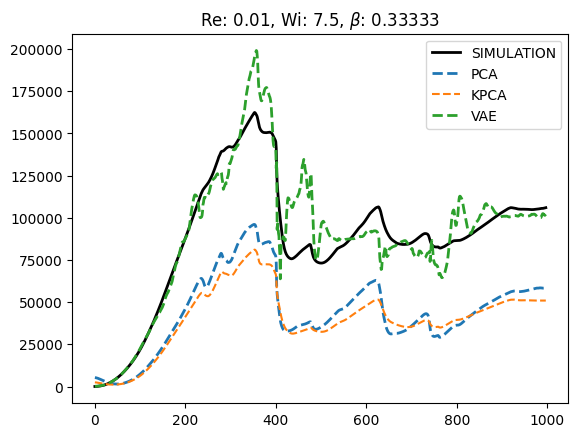

In [140]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)

plt.plot(total_linear[ini:fim],'--', label = 'PCA', lw = lw)
plt.plot(total_oldroyd[ini:fim],'--', label = 'KPCA')

plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

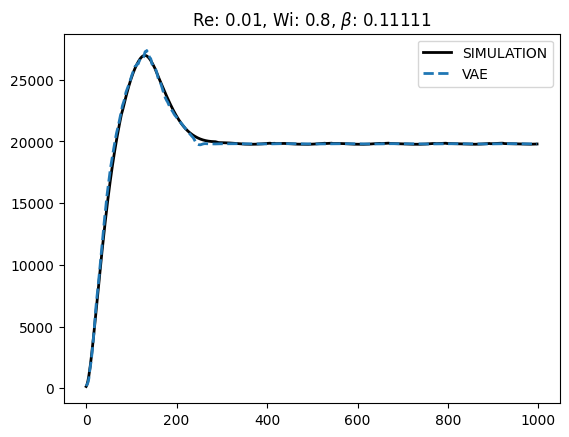

In [29]:
ini = 0
fim = -1
lw = 2
plt.plot(total[ini:fim], label = 'SIMULATION',color='k', lw = lw)
plt.plot(total_ae[ini:fim],'--', label = 'VAE', lw = lw)
plt.title(f'Re: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}')
plt.legend()

# plt.axvline(len(total) - 100,color = 'k', linestyle='dashed')
# plt.savefig(f'{imgdir}/Re{Re:g}_Wi{Wi:g}_beta{beta:g}.png')

In [57]:
## Visual Plots
X_rec = reconstruct_cross(X_ae.reshape((-1,5,999)), cut)
X_rec[:65-cut,:65-cut] = np.NaN
X_rec[-65+cut:,:65-cut] = np.NaN
X_rec[:65-cut,-65+cut:] = np.NaN
X_rec[-65+cut:,-65+cut:] = np.NaN

X_rec_lin = reconstruct_cross(X_linear.reshape((-1,5,999)), cut)
X_rec_lin[:65-cut,:65-cut] = np.NaN
X_rec_lin[-65+cut:,:65-cut] = np.NaN
X_rec_lin[:65-cut,-65+cut:] = np.NaN
X_rec_lin[-65+cut:,-65+cut:] = np.NaN

X_rec_old = reconstruct_cross(X_oldroyd.reshape((-1,5,999)), cut)
X_rec_old[:65-cut,:65-cut] = np.NaN
X_rec_old[-65+cut:,:65-cut] = np.NaN
X_rec_old[:65-cut,-65+cut:] = np.NaN
X_rec_old[-65+cut:,-65+cut:] = np.NaN

X_true = reconstruct_cross(X.reshape((-1,5,999)), cut)
X_true[:65-cut,:65-cut] = np.NaN
X_true[-65+cut:,:65-cut] = np.NaN
X_true[:65-cut,-65+cut:] = np.NaN
X_true[-65+cut:,-65+cut:] = np.NaN

tra_Ar = X_rec[...,2,:]**2 + X_rec[...,4,:]**2 + 2* X_rec[...,3,:]**2
tra_Ar_lin = X_rec_lin[...,2,:]**2 + X_rec_lin[...,4,:]**2 + 2* X_rec_lin[...,3,:]**2
tra_Ar_old = X_rec_old[...,2,:]**2 + X_rec_old[...,4,:]**2 + 2* X_rec_old[...,3,:]**2
tra_At = X_true[...,2,:]**2 + X_true[...,4,:]**2 + 2* X_true[...,3,:]**2

In [58]:
save_dir = f'Images/VAE_parametric_small/Wi_{Wi:g}_beta_{beta:g}'
os.makedirs(save_dir, exist_ok= True)
for t in range(X.shape[1]):
# for t in range(1):
    vmin = np.min([np.nanmin(tra_At[...,t]), np.nanmin(tra_Ar[...,t]), np.nanmin(tra_Ar_lin[...,t]), np.nanmin(tra_Ar_old[...,t])])
    vmax = np.max([np.nanmax(tra_At[...,t]), np.nanmax(tra_Ar[...,t]), np.nanmax(tra_Ar_lin[...,t]), np.nanmax(tra_Ar_old[...,t])])
    levels = np.linspace(vmin, vmax, 50)
    f, ax = plt.subplots(2,2, figsize = (10,12))

    ax[0,0].contourf(Xr_mesh,Yr_mesh,tra_At[...,t], levels=levels)
    ax[1,0].contourf(Xr_mesh,Yr_mesh,tra_Ar_lin[...,t], levels=levels)

    ax[0,0].set_title('Simulation')
    ax[1,0].set_title('PCA')

    surf = ax[0,1].contourf(Xr_mesh,Yr_mesh,tra_Ar[...,t], levels=levels)
    ax[1,1].contourf(Xr_mesh,Yr_mesh,tra_Ar_old[...,t], levels=levels)
    ax[0,1].set_title('VAE')
    ax[1,1].set_title('KPCA')
    f.suptitle(f'Trace of Conformation\nRe: {Re:g}, Wi: {Wi:g}, $\\beta$: {beta:g}\nt = {t*4e-2:g}')
    ax[0,0].set_xticks([])
    ax[1,0].set_xticks([])
    ax[0,0].set_yticks([])
    ax[1,0].set_yticks([])
    ax[0,1].set_xticks([])
    ax[1,1].set_xticks([])
    ax[0,1].set_yticks([])
    ax[1,1].set_yticks([])
    f.tight_layout()
    plt.colorbar(surf, ax = ax, location='bottom')
    f.savefig(f'{save_dir}/frame_{t}.png')
    plt.close()
    

In [59]:
video_cmd = f'ffmpeg -framerate 25 -i frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p Wi{Wi:g}_beta{beta:g}.mp4'
video_cmd

'ffmpeg -framerate 25 -i frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p Wi4_beta0.22222.mp4'

Text(0.5, 1.0, 'Dataset parameters distribuition')

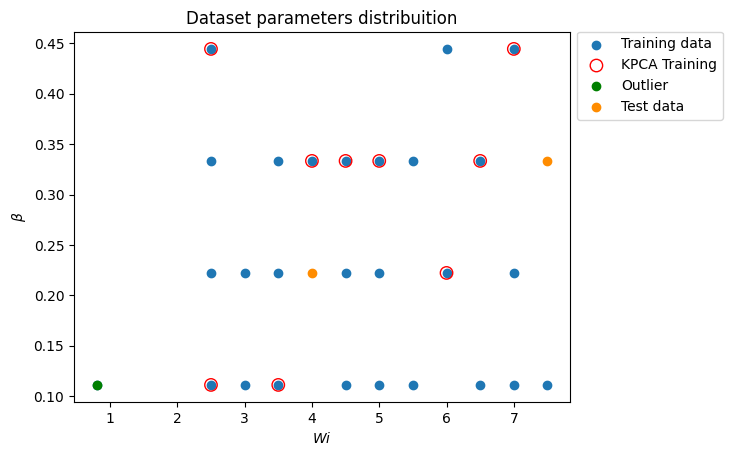

In [179]:
arr_p = np.array(parameters)
step = 3
init = 1
plt.scatter(arr_p[:-2,0],arr_p[:-2,1], label = 'Training data')
# plt.plot(arr_p[init:-2:step,0],arr_p[init:-2:step,1], 'ms', label = 'KPCA\nTraining')
plt.scatter(arr_p[init:-2:step,0],arr_p[init:-2:step,1], s=80, facecolors='none', edgecolors='r',label = 'KPCA Training')
plt.scatter(arr_p[0,0],arr_p[0,1], c='g', label = 'Outlier')
plt.scatter(arr_p[-2:,0],arr_p[-2:,1], c='darkorange', label = 'Test data')

plt.ylabel('$\\beta$')
plt.xlabel('$Wi$')
plt.legend(bbox_to_anchor=(1., 1.02))
plt.title('Dataset parameters distribuition')